In [1]:
import pandas as pd
import numpy as np
import random
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('RL_dataset.csv',index_col=0)
print(df.shape)
df.columns

(30001, 18)


Index(['user_id', 'age', 'ip_location', 'current_browsing_time',
       'pages_visited', 'discount', 'referral_source', 'onboarding_time',
       'kyc_type', 'browser_type', 'payment_method', 'time_of_day',
       'planned_monthly_deposit', 'device', 'device_model',
       'base_suggested_amount', 'suggested_amount_after_discount',
       'user_action'],
      dtype='object')

In [61]:
# Encode categorical features using dummy encoding
categorical_features = ['ip_location',
                        'referral_source', 
                        'kyc_type',
                        'browser_type',
                        'payment_method',
                        'time_of_day',
                        'planned_monthly_deposit',
                        'device',
                        'device_model'
                       ]
df_encoded = pd.get_dummies(df, columns=categorical_features)

# Normalize numerical features
numerical_features = ['age',
                      'current_browsing_time',
                      'pages_visited',
                      'onboarding_time',
                      'base_suggested_amount']
scaler = StandardScaler()
df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])


In [62]:
df_encoded[['user_action','discount']].value_counts(normalize=True,dropna=False)*100

user_action  discount
100          5           18.502717
200          15          18.136062
             10          16.352788
100          10          14.729509
             15          13.719543
200          5           12.312923
300          5            2.513250
             10           1.946602
             15           1.786607
dtype: float64

In [63]:
# Split the dataset into features (X) and labels (y)
X = df_encoded.drop(columns=['user_action'])
y = df_encoded['user_action']

In [64]:
# Split the data into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Display the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(X_train.columns)

X_train shape: (15000, 68)
X_test shape: (15001, 68)
y_train shape: (15000,)
y_test shape: (15001,)
Index(['user_id', 'age', 'current_browsing_time', 'pages_visited', 'discount',
       'onboarding_time', 'base_suggested_amount',
       'suggested_amount_after_discount', 'ip_location_AZ', 'ip_location_CA',
       'ip_location_CO', 'ip_location_FL', 'ip_location_MI', 'ip_location_NV',
       'ip_location_NY', 'ip_location_TX', 'ip_location_UT', 'ip_location_WA',
       'referral_source_Facebook', 'referral_source_Google',
       'referral_source_Instagram', 'referral_source_Telegram',
       'referral_source_Tiktok', 'referral_source_URL',
       'kyc_type_driver_license', 'kyc_type_national_id', 'kyc_type_passport',
       'browser_type_Chrome', 'browser_type_Edge', 'browser_type_Firefox',
       'browser_type_Safari', 'payment_method_Credit Card',
       'payment_method_Cryptocurrency', 'payment_method_PayPal',
       'time_of_day_Afternoon', 'time_of_day_Evening', 'time_of_day_Mornin

In [65]:
relevant_cols = ['user_id',
                'age', 
                'current_browsing_time',
                'pages_visited',
                'discount',
                'suggested_amount_after_discount',
                'onboarding_time',
                'referral_source_Facebook',
                'referral_source_Google',
                'referral_source_Instagram',
                'referral_source_Telegram',
                'referral_source_Tiktok',
                'referral_source_URL',
                'payment_method_Credit Card',
                'payment_method_Cryptocurrency',
                'payment_method_PayPal',
                'time_of_day_Afternoon',
                'time_of_day_Evening',
                'time_of_day_Morning',
                'time_of_day_Night',
                'device_Android',
                'device_MacOS',
                'device_Others',
                'device_Windows',
                'device_iOS']
X_train = X_train[relevant_cols]
X_test = X_test[relevant_cols]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (15000, 25)
X_test shape: (15001, 25)


In [66]:
# Define the state as the concatenation of all feature columns except 'discount' and 'user_action'
state_features = [col for col in X_train.columns if col not in ['discount', 
                                                                'user_id',
                                                                'user_action',
                                                                'suggested_amount_after_discount']]
states = X_train[state_features].values

# Define the actions (discounts) and rewards (user_action)
actions = X_train['discount'].values

minor_penalty = -0.5
# minor_penalty = 0

big_penalty = -1.5

rewards = np.where(y_train == 200, 2 * np.log10(X_train['suggested_amount_after_discount']), 0)
# rewards = np.where(y_train == 200, 1, 0)


rewards = np.where(y_train == 100, minor_penalty, rewards)
# rewards = np.where(y_train == 300, big_penalty, rewards)
rewards = np.where(y_train == 300, -np.log10(X_train['suggested_amount_after_discount']), rewards)


print("State shape:", states.shape)
print("Actions shape:", actions.shape)
print("Rewards shape:", rewards.shape)


State shape: (15000, 22)
Actions shape: (15000,)
Rewards shape: (15000,)


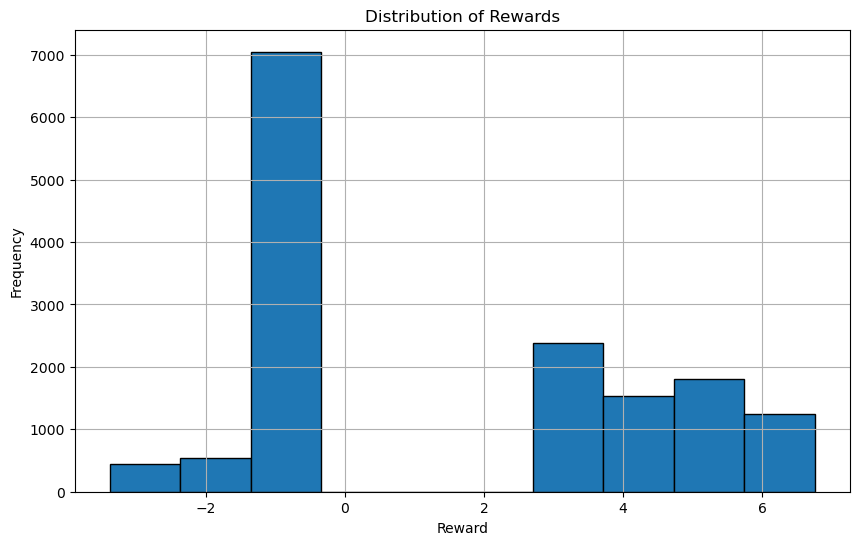

In [67]:
# Plot the distribution of the rewards
plt.figure(figsize=(10, 6))
plt.hist(rewards, bins=10, edgecolor='black')
plt.title('Distribution of Rewards')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [68]:
from q_learning_agent import QLearningAgent
from QLearningLogger import QLearningLogger
# Initialize the Q-learning agent
n_actions = 3  # Corresponding to discounts 5%, 10%, 15%
state_size = len(state_features)
agent = QLearningAgent(n_actions, state_size)
logger = QLearningLogger(agent, states)
q_values_history, exploration_rate_history = logger.log_training(episodes=5000, rewards=rewards, log_interval=5)

# q_values_history, exploration_rate_history = log_training(agent, states, 100000)

Episode 0: Exploration Rate = 1.0000
Q-values for a selected state: [0.         0.00026767 0.        ]
Episode 5: Exploration Rate = 0.9997
Q-values for a selected state: [0.         0.00022553 0.        ]
Episode 10: Exploration Rate = 0.9995
Q-values for a selected state: [ 0.0e+00 -2.5e-05  0.0e+00]
Episode 15: Exploration Rate = 0.9992
Q-values for a selected state: [0.00029542 0.         0.        ]
Episode 20: Exploration Rate = 0.9990
Q-values for a selected state: [ 0.0e+00  0.0e+00 -2.5e-05]
Episode 25: Exploration Rate = 0.9987
Q-values for a selected state: [-2.5e-05  0.0e+00  0.0e+00]
Episode 30: Exploration Rate = 0.9985
Q-values for a selected state: [-2.5e-05  0.0e+00  0.0e+00]
Episode 35: Exploration Rate = 0.9982
Q-values for a selected state: [0.         0.00016284 0.        ]
Episode 40: Exploration Rate = 0.9980
Q-values for a selected state: [0.         0.         0.00033522]
Episode 45: Exploration Rate = 0.9977
Q-values for a selected state: [0.00026284 0.       

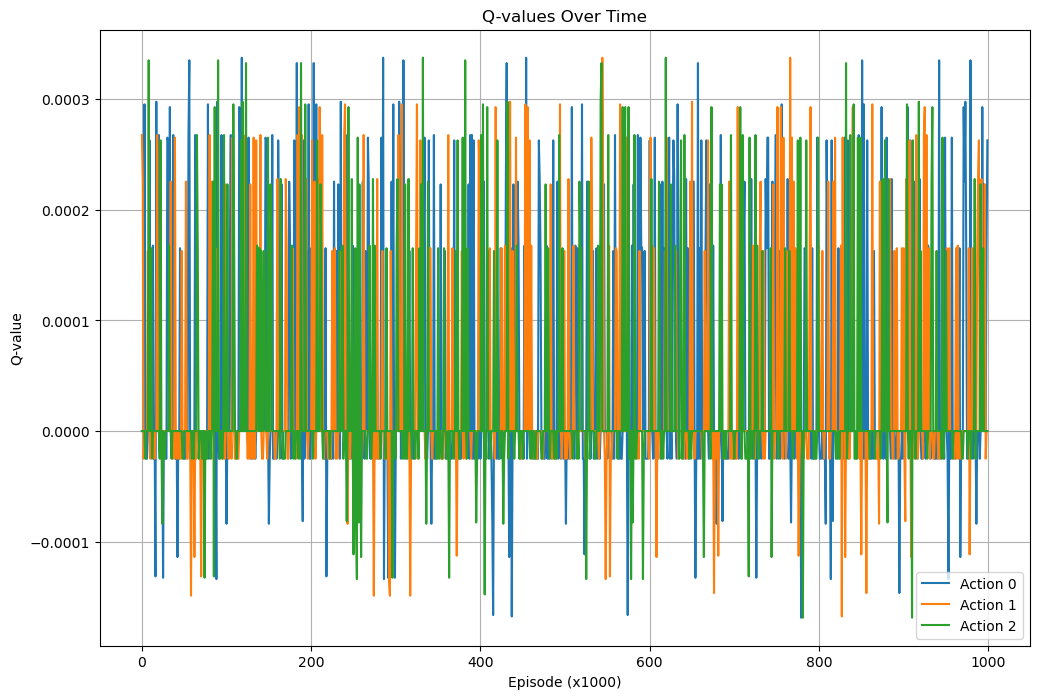

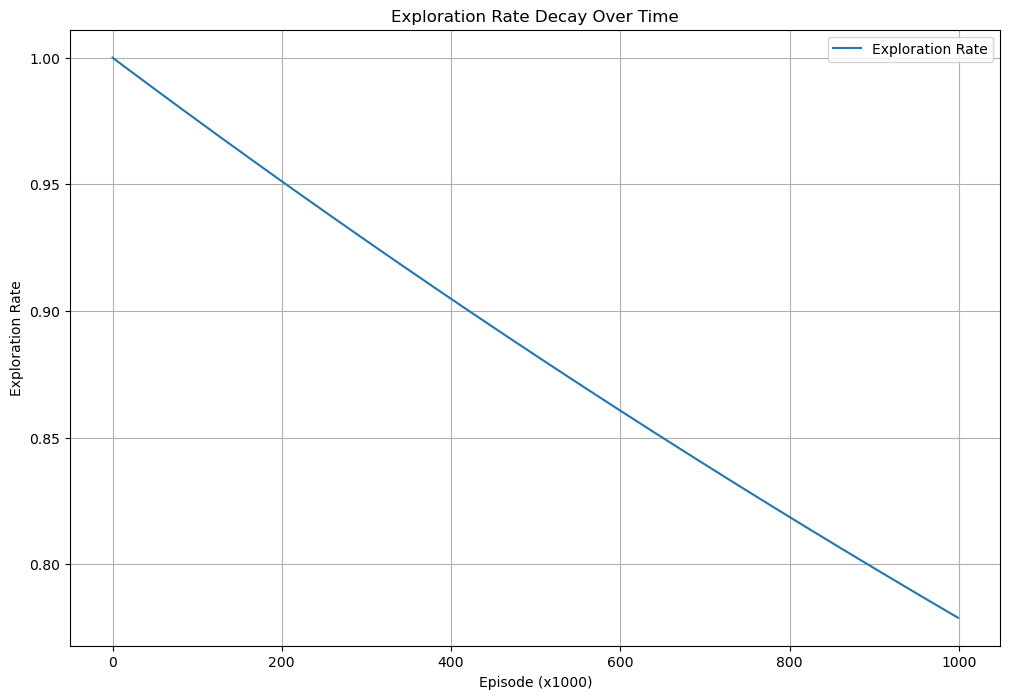

In [69]:
logger.plot_q_values(q_values_history)
logger.plot_exploration_rate(exploration_rate_history)

In [70]:
# Function to get the agent's chosen actions for the dataset
def get_agent_actions(agent, X):
    actions = []
    for _, row in X.iterrows():
        state = tuple(row.values)  # Convert row to a tuple to use as a state
        action = agent.choose_action(state)
        actions.append(action)
    return np.array(actions)

In [71]:
# Get the agent's chosen actions for the original dataset
agent_actions = get_agent_actions(agent, X_train)

# Assuming df_encoded has a column 'assigned_discount' to compare with
X_train['agent_action'] = agent_actions
X_train.agent_action.value_counts(normalize=True)

0    0.483933
2    0.260533
1    0.255533
Name: agent_action, dtype: float64

In [72]:
# Merge with the original dataframe to get user actions
comparison = X_train[['discount', 'agent_action', 'user_id']].merge(
    df_encoded[['user_id', 'user_action']], on='user_id')

# Map agent actions to discount values
discount_mapping = {0: 5, 1: 10, 2: 15}
comparison['agent_discount'] = comparison['agent_action'].map(discount_mapping)

# Compare user actions with agent's chosen discounts
comparison_counts = comparison[['user_action', 'agent_discount', 'discount']].value_counts(normalize=True)
comparison_counts = comparison_counts.reset_index()

/tmp/ipykernel_32355/1626046297.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paying_users.rename(columns={0: 'normalized_value'}, inplace=True)


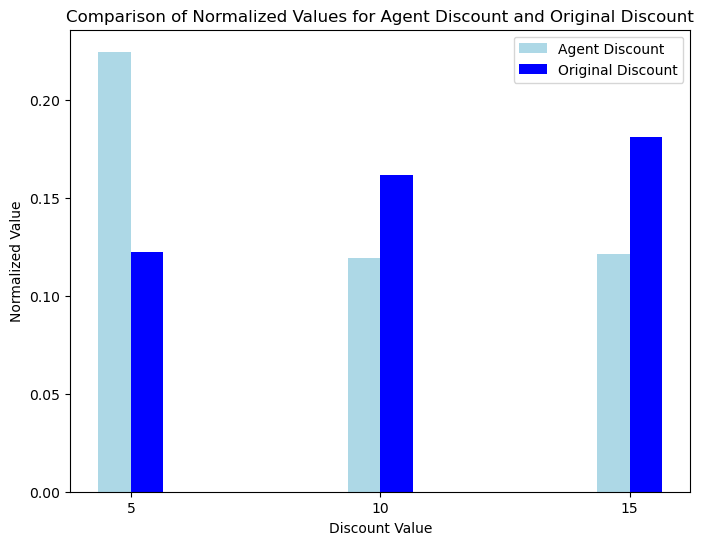

In [73]:
paying_users = comparison_counts[comparison_counts['user_action'] == 200]

paying_users.rename(columns={0: 'normalized_value'}, inplace=True)

agent_discounts = paying_users.groupby('agent_discount')['normalized_value'].sum()
original_discounts = paying_users.groupby('discount')['normalized_value'].sum()

# Align the indexes
all_discounts = sorted(set(agent_discounts.index).union(set(original_discounts.index)))
agent_discounts = agent_discounts.reindex(all_discounts, fill_value=0)
original_discounts = original_discounts.reindex(all_discounts, fill_value=0)

# Plotting the data as a bar chart
plt.figure(figsize=(8, 6))
width = 0.65  # Width of the bars

# Plot agent_discount
plt.bar([x - width/2 for x in all_discounts], agent_discounts, width, label='Agent Discount', color='lightblue')

# Plot discount
plt.bar([x + width/2 for x in all_discounts], original_discounts, width, label='Original Discount',color='blue')

plt.xlabel('Discount Value')
plt.ylabel('Normalized Value')
plt.title('Comparison of Normalized Values for Agent Discount and Original Discount')
plt.xticks(all_discounts)
plt.legend()
plt.show()

In [75]:
# Get the agent's chosen actions for the original dataset
agent_actions = get_agent_actions(agent, X_test)

# Assuming df_encoded has a column 'assigned_discount' to compare with
X_test['agent_action'] = agent_actions

# Map agent actions to discount values
discount_mapping = {0: 5, 1: 10, 2: 15}
X_test['agent_discount'] = X_test['agent_action'].map(discount_mapping)
X_test.agent_action.value_counts(normalize=True)

0    0.475168
1    0.267715
2    0.257116
Name: agent_action, dtype: float64

In [76]:
X_test.to_csv('with_agent_action.csv')